In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Resizing , Rescaling,InputLayer,Conv2D,BatchNormalization,MaxPool2D,Dropout,Flatten,Dense, RandomRotation ,RandomFlip,RandomContrast,Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2
from tensorflow.keras import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy , SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy , TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
import  cv2
import numpy
from tensorflow.math import confusion_matrix
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
import tensorflow_probability as tfp
from keras.src.layers import GlobalAveragePooling2D

# DATA LOADING

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 93% 287M/309M [00:01<00:00, 267MB/s]
100% 309M/309M [00:01<00:00, 258MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [ ]:
train_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/train'
validation_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/test'
class_name = ["angry","happy","sad"]
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
c=[]
cont=0
for i in val_dataset.take(1):
  print(i)
  cont+=1
  c.append(cont)
print(c)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

# DATA VISUALIZATION

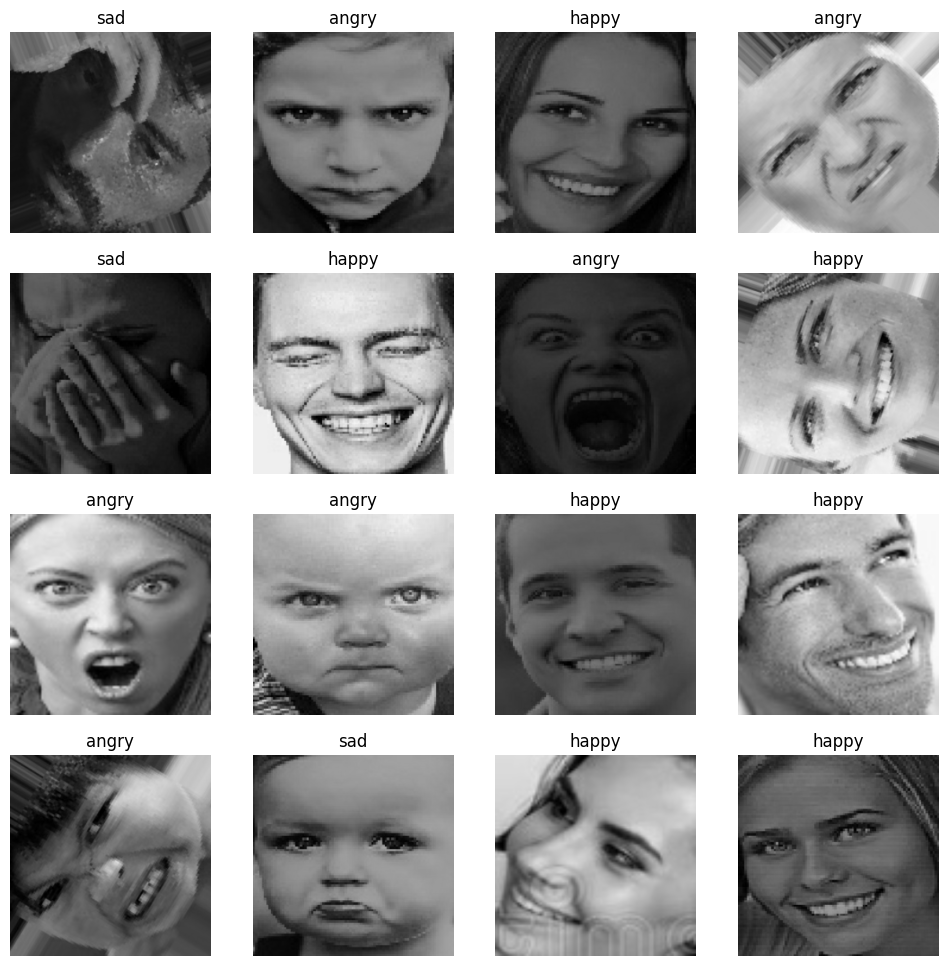

In [ ]:
plt.figure(figsize=(12,12))

for image,label in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image[i]/256)
    plt.title(class_name[tf.argmax(label[i],axis=0).numpy()])
    plt.axis("off")

# DATA AGUMENTATION

In [ ]:
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

# DATA PREPERATION

In [ ]:
train_dataset_1 = train_dataset.map(augment_data, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_data, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
"""training_dataset = (train_dataset
                    .map(augment_data,num_parallel_calls=tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))"""

'training_dataset = (train_dataset\n                    .map(augment_data,num_parallel_calls=tf.data.AUTOTUNE)\n                    .prefetch(tf.data.AUTOTUNE))'

In [ ]:
training_dataset = (mixed_dataset
                    .map(cutmix,num_parallel_calls=tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [ ]:
validation_dataset = (val_dataset.prefetch(tf.data.AUTOTUNE))

In [ ]:
rescaling_resizing = Sequential([
    Resizing(CONFIGURATION["IM_SIZE"],CONFIGURATION['IM_SIZE']),
    Rescaling(1./255)
])

# MODELING

In [ ]:
IM_SIZE = 224
lenet_model = Sequential()


lenet_model.add(InputLayer(input_shape = (None, None, 3)))
lenet_model.add(rescaling_resizing)

lenet_model.add(Conv2D(filters = CONFIGURATION['N_FILTERS'], kernel_size= CONFIGURATION['KERNEL_SIZE'],
                       strides=CONFIGURATION['N_STRIDES'],
                       activation = 'relu'))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],  strides = CONFIGURATION['N_STRIDES']*2))
lenet_model.add(Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ))


lenet_model.add(Conv2D(filters= CONFIGURATION['N_FILTERS']*2+4, kernel_size =  CONFIGURATION['KERNEL_SIZE'],
                       strides =  CONFIGURATION['N_STRIDES'],
                       padding='valid',
                       activation = 'relu'))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool2D (pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2))

lenet_model.add(Flatten())

lenet_model.add(Dense(units = CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])))
lenet_model.add(BatchNormalization())

lenet_model.add(Dropout(rate = CONFIGURATION["DROPOUT_RATE"]))

lenet_model.add(Dense(units = CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])))
lenet_model.add(BatchNormalization())

lenet_model.add(Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"))


lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

# TRAINING

In [ ]:
loss_function = CategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name='accuracy'),TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate=(CONFIGURATION['LEARNING_RATE'])),
                    loss=loss_function,
                    metrics=metrics)

In [ ]:
history = lenet_model.fit(training_dataset,
                          validation_data=validation_dataset,
                          epochs=CONFIGURATION['N_EPOCHS'],
                          verbose=1)

Epoch 1/20
  6/213 [..............................] - ETA: 12:37 - loss: 2.5115 - accuracy: 0.3385 - top_k_accuracy: 0.6771

KeyboardInterrupt: ignored

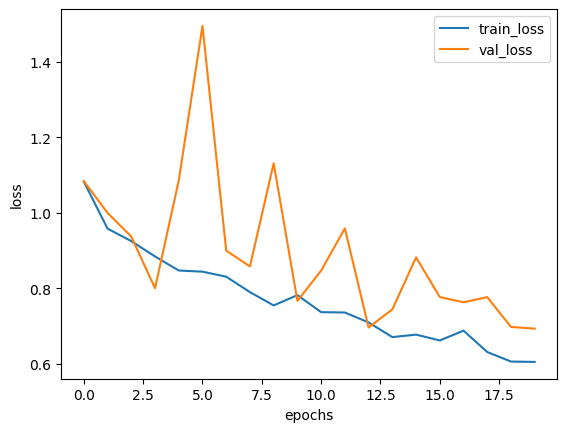

In [ ]:
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

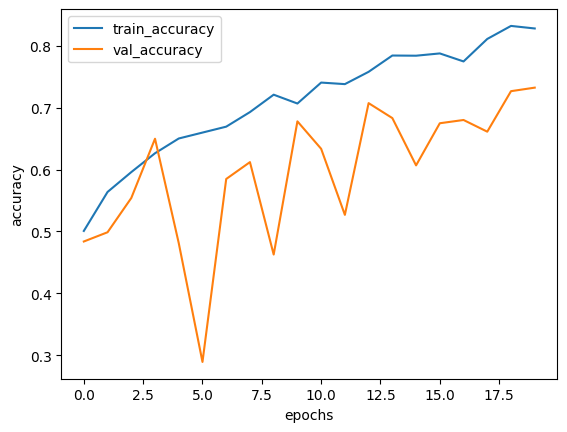

In [ ]:
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# EVALUATION AND TESTING

In [ ]:
lenet_model.evaluate(validation_dataset)

In [ ]:
lenet_model.save('lenet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


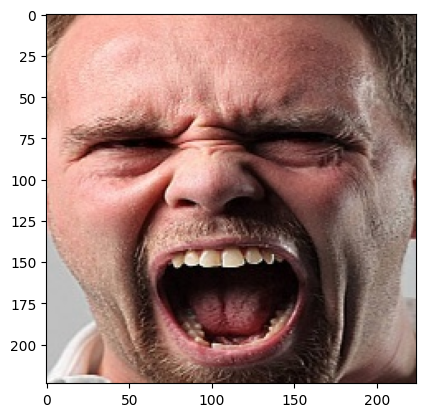

In [ ]:

test_image = cv2.imread("/content/dataset/EmotionsDataset/data/angry/1049.jpg")
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
image = tf.constant(test_image_rgb,dtype=tf.float32)/255
plt.imshow(image)

In [ ]:
im = tf.constant(test_image,dtype=tf.float32)
im = tf.expand_dims(im , axis=0)
print(class_name[tf.argmax(lenet_model.predict(im),axis=-1).numpy()[0]])

1/1 [==============================] - 0s 19ms/step
angry


In [ ]:
predicted=[]
labels =[]
for im ,label in validation_dataset:
  predicted.append(lenet_model.predict(im))
  labels.append(label.numpy())

1/1 [==============================] - 0s 44ms/step


In [ ]:
print(numpy.argmax(labels[:-1],axis=-1).flatten())
print(numpy.argmax(predicted[:-1],axis=-1).flatten())

[1 1 2 ... 1 1 2]
[2 2 2 ... 1 2 1]


In [ ]:
pred = numpy.argmax(labels[:-1],axis=-1).flatten()
lab = numpy.argmax(predicted[:-1],axis=-1).flatten()

tf.Tensor(
[[312  75  71]
 [ 53 602  62]
 [149 326 622]], shape=(3, 3), dtype=int32)


Text(0.5, 1.0, 'confusion matrix')

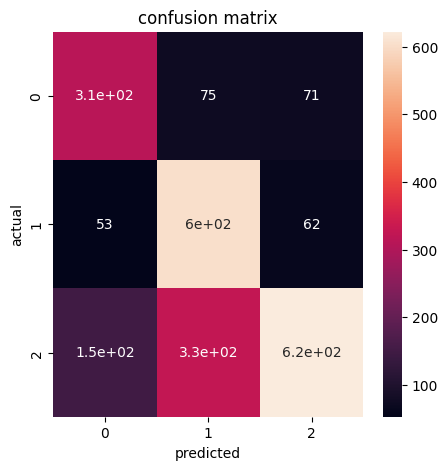

In [ ]:
cm = confusion_matrix(lab,pred)

print(cm)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)
plt.ylabel('actual')
plt.xlabel("predicted")
plt.title('confusion matrix')

# PreTrained Model

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),
    pooling=None,
)

In [ ]:
backbone.trainnable = False       ### freezing the model

In [ ]:


model = tf.keras.Sequential([
    Input(shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION['N_DENSE_1'],activation='relu'),
    BatchNormalization(),
    Dense(CONFIGURATION['N_DENSE_2'],activation='relu'),
    Dense(CONFIGURATION['NUM_CLASSES'],activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                        

In [ ]:

checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [ ]:
loss = CategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name='accuracy'),TopKCategoricalAccuracy(k=2,name='top k accuracy')]

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=loss,
    metrics=metrics,
)

In [ ]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=3)

Epoch 1/3


In [ ]:
model.save("/content/drive/MyDrive/eff_netB4.h5")

# Evaluation

In [ ]:
model.load_weights('best_weights')

NotFoundError: ignored

In [ ]:
model.evaluate(val_dataset)

72/72 [==============================] - 15s 205ms/step - loss: 0.4362 - accuracy: 0.8428 - top k accuracy: 0.9486


[0.43623366951942444, 0.8428446054458618, 0.9486391544342041]

In [ ]:
im = tf.constant(test_image,dtype=tf.float32)
im = tf.expand_dims(im , axis=0)
print(class_name[tf.argmax(model.predict(im),axis=-1).numpy()[0]])

ValueError: ignored

# Fine Tuning

In [ ]:
backbone.trainable =True

NameError: ignored

In [ ]:

input =    Input(shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3))
x =   backbone(input,training=False)
x =   GlobalAveragePooling2D()(x)
x =   Dense(CONFIGURATION['N_DENSE_1'],activation='relu')(x)
x= BatchNormalization()(x)
x =   Dense(CONFIGURATION['N_DENSE_2'],activation='relu')(x)
output =   Dense(CONFIGURATION['NUM_CLASSES'],activation='softmax')(x)


NameError: ignored

In [ ]:
fintuned_model = Model(input,output)

In [ ]:
fintuned_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_7  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_15 (Dense)            (None, 1024)              1836032   
                                                                 
 batch_normalization_5 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                           

In [ ]:
fintuned_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=loss,
    metrics=metrics,
)

In [ ]:
#history = fintuned_model.fit(train_dataset,validation_data=val_dataset,epochs=5)

# Visualizing the blackbox

In [ ]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),

)

In [ ]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else :
    False

In [ ]:
feature_map = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name) == True]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_map
)

feature_map_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

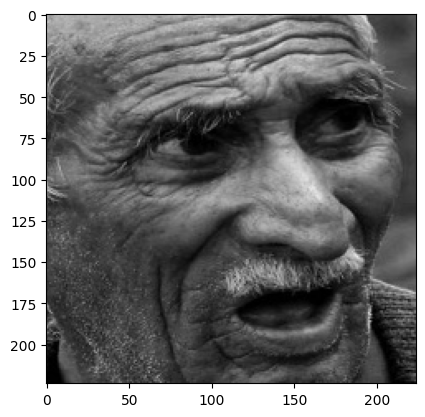

In [ ]:

test_image = cv2.imread("/content/dataset/EmotionsDataset/data/angry/1002.jpg")
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
image = tf.constant(test_image_rgb,dtype=tf.float32)/255
plt.imshow(image)

In [ ]:
test_image = cv2.imread("/content/dataset/EmotionsDataset/data/angry/1002.jpg")
test_image = cv2.resize(test_image,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))

im = tf.constant(test_image,dtype=tf.float32)
im = tf.expand_dims(im,axis=0)

f_map = feature_map_model.predict(im)

1/1 [==============================] - 8s 8s/step


In [ ]:
for i in range(len(f_map)):
  print(f_map[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [ ]:
import numpy as np
for i in range(len(f_map)):
  plt.figure(figsize=(256,256))
  f_size = f_map[i].shape[1]
  n_channel = f_map[i].shape[3]
  joint_maps=np.ones((f_size,f_size*n_channel))
  axs = plt.subplot(len(f_map),1,i+1)
  for j in range(n_channel):
    joint_maps[:,f_size*j:f_size*(j+1)] = f_map[i][...,j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis('off')

# GRAD CAM

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

115263384/115263384 [==============================] - 6s 0us/step


In [ ]:
x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0][0]'] 

In [ ]:
#pretrained_model.load_weights('best_weights')

NotFoundError: ignored

# ENSEMBLING

In [ ]:
inputs =  Input(shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3))

y1 = pretrained_model(inputs)
y2 = model(inputs)

output = 0.5*y1+0.5*y2

ensamble_model = Model(inputs=input,outputs = output)

# EXPORTING TO ONNX FORMAT

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.1 MB/s eta 0:00:00


**CONVERSION**

In [ ]:
!python -m tf2onnx.convert --saved-model lenet_model/ --output lenet_onnx.onnx

2023-10-21 13:27:36.711138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-10-21 13:27:39.356981: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-21 13:27:39,357 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-10-21 13:27:39.888348: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251920384 exceeds 10% of free system memory.
2023-10-21 13:27:39.888406: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251920384 exceeds 10% of free system memory.
2023-10-21 13:27:39.888577: W tensorflow/tsl/fr

**INFERENCE**

In [ ]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec(
    (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    tf.float32, name="input"),)

output_path = "lenet_keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(lenet_model, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

In [ ]:
output_names

['dense_2']

In [ ]:
import numpy as np
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = test_image.astype(np.float32)

im = np.expand_dims(im, axis = 0)

In [ ]:
providers = ['GPUExecutionProvider']
m = rt.InferenceSession(output_path,providers=providers)

onnx_pred = m.run(output_names,{"input": im})

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'GPUExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


EP Error Unknown Provider Type: GPUExecutionProvider when using ['GPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.


In [ ]:
onnx_pred

[array([[0.00398579, 0.02483415, 0.9711801 ]], dtype=float32)]

In [ ]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 89.7 MB/s eta 0:00:00


# Quantaization

In [ ]:
import onnxruntime

onnx_model = onnxruntime.InferenceSession("/content/drive/MyDrive/lenet_keras.onnx")


In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic,QuantType

In [ ]:
model_fp32 = '/content/drive/MyDrive/lenet_keras.onnx'
model_quant = '/content/lenet_quantized'

quantized_model = quantize_dynamic(model_fp32,model_quant,weight_type = QuantType.QUInt8)

In [ ]:
import onnxruntime as rt
providers = ['CPUExecutionProvider']
model = rt.InferenceSession("/content/lenet_quantized",providers=providers)


In [ ]:
output_names = [n.name for n in model.graph.output]
model.run(output_names,{'input':np.array(im)})

NameError: ignored